In [43]:
import keras

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU, Dropout, Activation
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from IPython import display
from tensorflow.keras.datasets import mnist

import time
import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

from tqdm.auto import tqdm

tensorflow version: 2.10.0


In [44]:
def plot_array(X,title=""):
    
    plt.rcParams['figure.figsize'] = (20,20) 

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

In [45]:
img_height, img_width, batch_size=32,32,128

In [46]:
# Load and preprocess the MNIST dataset
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)
X_train = tf.image.resize(X_train, [img_height, img_width])

In [47]:
X_train.shape

TensorShape([60000, 32, 32, 1])

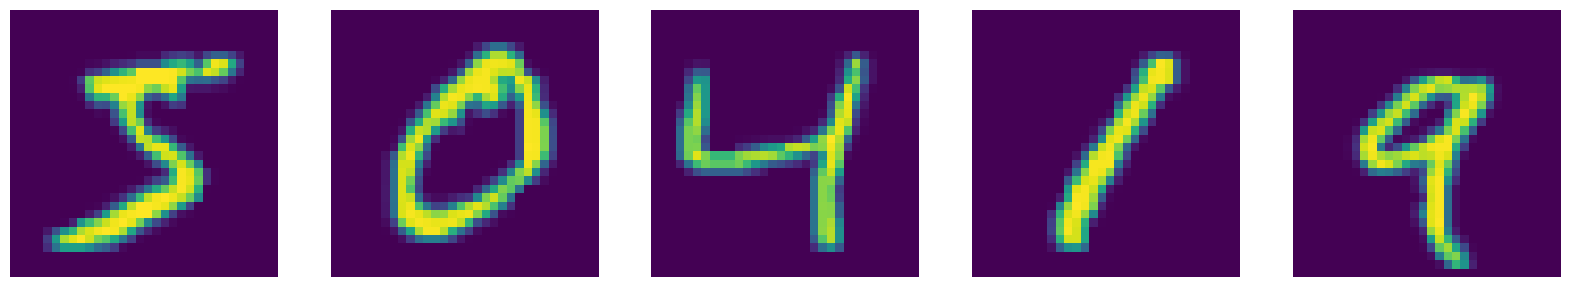

In [48]:
plot_array(X_train)

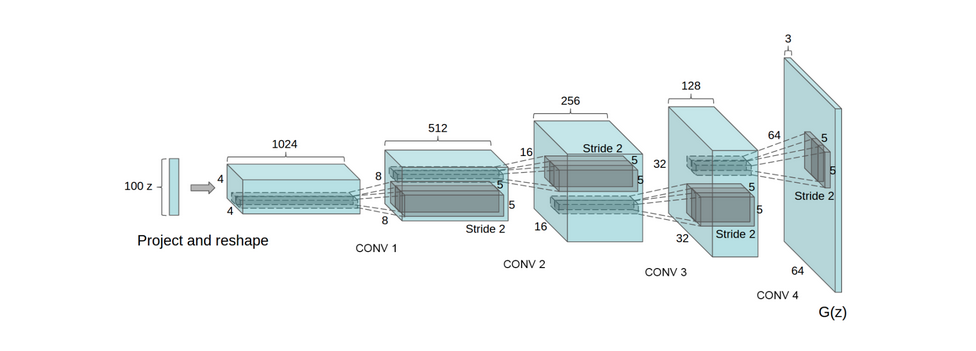

In [49]:
####Define the Generator

def build_generator():

    model = Sequential()
    
    
    model.add(Input(shape=(1, 1, 100)))
    model.add(Conv2DTranspose(64*16, kernel_size=4, strides=4, padding="same", 
                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False))
    model.add(BatchNormalization(momentum=0.9,gamma_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.02),
                                         beta_initializer='zeros'
                                ))
    model.add(ReLU())
    
    model.add(Conv2DTranspose(64*8, kernel_size=4, strides=2, padding="same", 
                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False))
    model.add(BatchNormalization(momentum=0.9,gamma_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.02),
                                         beta_initializer='zeros'
                                ))
    model.add(ReLU())
    
    model.add(Conv2DTranspose(64*4, kernel_size=4, strides=2, padding="same", 
                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False))
    model.add(BatchNormalization(momentum=0.9,gamma_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.02),
                                         beta_initializer='zeros'
                                ))
    model.add(ReLU())
    
    model.add(Conv2DTranspose(64*2, kernel_size=4, strides=2, padding="same", 
                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)),
    model.add(ReLU())
    
    model.add(Conv2DTranspose(1, kernel_size=4, padding="same", 
                        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, 
                              #activation="tanh"
                             ))
    model.add(Activation("tanh"))

    
    

    return model

In [50]:
generator = build_generator()
generator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_30 (Conv2D  (None, 4, 4, 1024)       1638400   
 Transpose)                                                      
                                                                 
 batch_normalization_33 (Bat  (None, 4, 4, 1024)       4096      
 chNormalization)                                                
                                                                 
 re_lu_24 (ReLU)             (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_31 (Conv2D  (None, 8, 8, 512)        8388608   
 Transpose)                                                      
                                                                 
 batch_normalization_34 (Bat  (None, 8, 8, 512)        2048      
 chNormalization)                                    

In [51]:
###Define the discriminator

def build_discriminator():


    model = Sequential()
    model.add(Input(shape=(32,32,1)))
    
    model.add(Conv2D(64, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(64*2, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False))
    model.add(BatchNormalization(momentum=0.9, 
                                 gamma_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.02),
                                 beta_initializer='zeros'
                                ))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(64*4, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False))
    model.add(BatchNormalization(momentum=0.9, 
                                 gamma_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.02),
                                 beta_initializer='zeros'
                                ))
    model.add(LeakyReLU(0.2))
    
    
    
    model.add(Conv2D(64*8, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False))
    model.add(BatchNormalization(momentum=0.9, 
                                 gamma_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.02),
                                 beta_initializer='zeros'
                                ))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(1, kernel_size=4, strides=2, padding="same", 
                     kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), 
                     use_bias=False, #activation="sigmoid"
                    ))
    model.add(Activation("sigmoid"))
    
    

    

    return model

In [52]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        1024      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 8, 128)         131072    
                                                                 
 batch_normalization_36 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 4, 4, 256)         524288    
                                                     

In [53]:
import os

def save_generated_images(generator, epoch):
    r, c = 5, 5  # Number of rows and columns of generated images
    noise = np.random.normal(0, 1, (r * c,) + noise_shape)
    generated_images = generator.predict(noise)

    # Rescale generated images to [0, 1]
    generated_images = 0.5 * generated_images + 0.5

    # Create a directory to save the generated images
    save_dir = "generated_images_mnist"
    os.makedirs(save_dir, exist_ok=True)

    # Save the generated images
    for i in range(r * c):
        img = generated_images[i, :, :, :]
        img = np.squeeze(img)  # Remove the channel dimension if exists
        img = (img * 255).astype(np.uint8)  # Scale to [0, 255]
        file_path = os.path.join(save_dir, f"generated_image_epoch_{epoch}_sample_{i}.png")
        plt.imsave(file_path, img, cmap='gray')

    print(f"Generated images saved for epoch {epoch}.")



In [54]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [55]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [56]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

In [57]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

In [58]:
@tf.function

def train_step(X):
    
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample 
        xhat = generator(z, training=True)
        #the output of the discriminator for real data 
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)
        
        #loss for each 
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

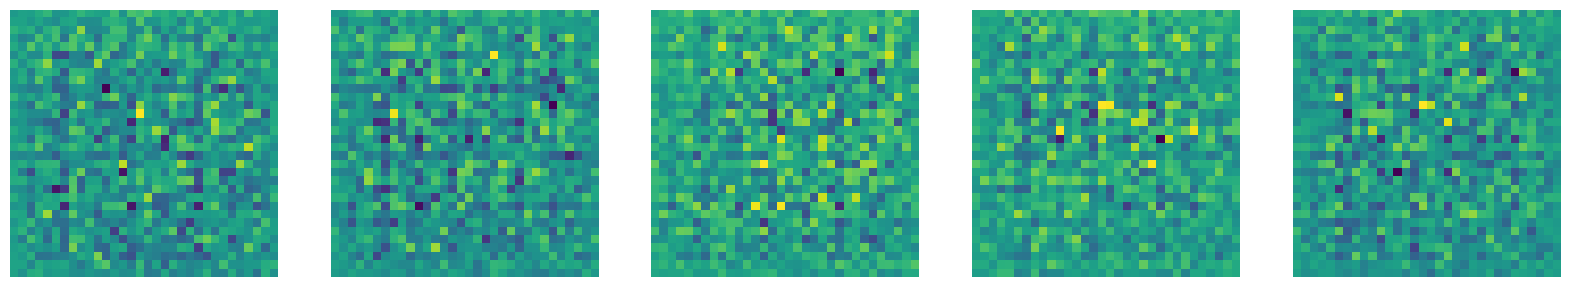

In [59]:
generator= build_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

In [60]:
epochs=20

discriminator=build_discriminator()

generator= build_generator()

Epoch 1


469batch [01:12,  6.46batch/s, Remaining Time=00:06]                      


generated images


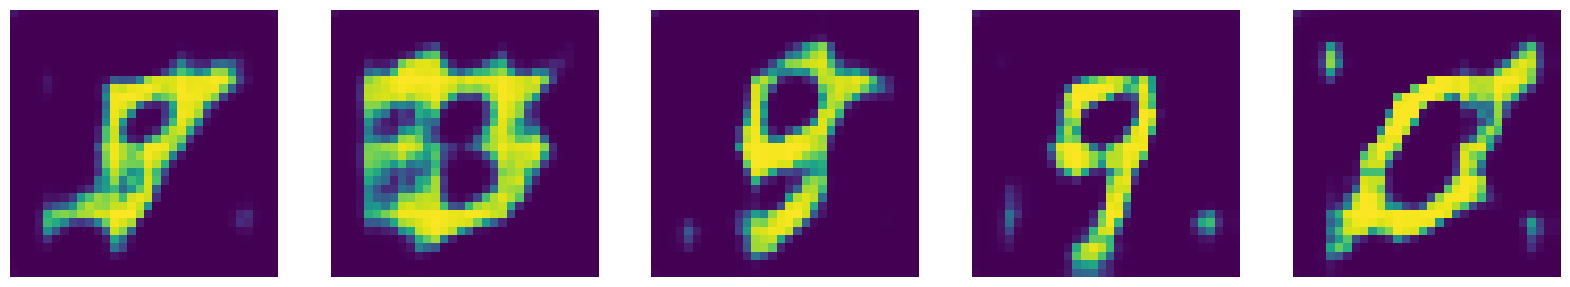

Epoch 2


469batch [01:11,  6.55batch/s, Remaining Time=00:03]                      


generated images


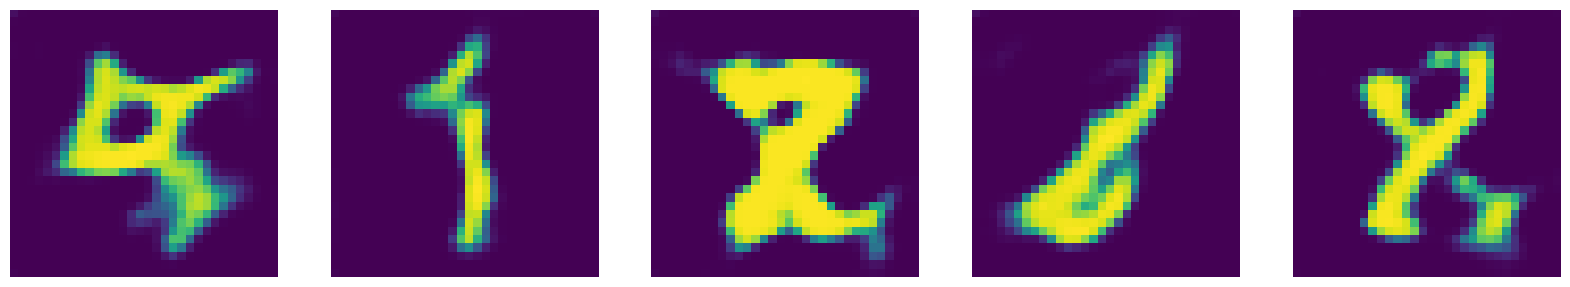

Epoch 3


469batch [01:12,  6.50batch/s, Remaining Time=00:02]                      


generated images


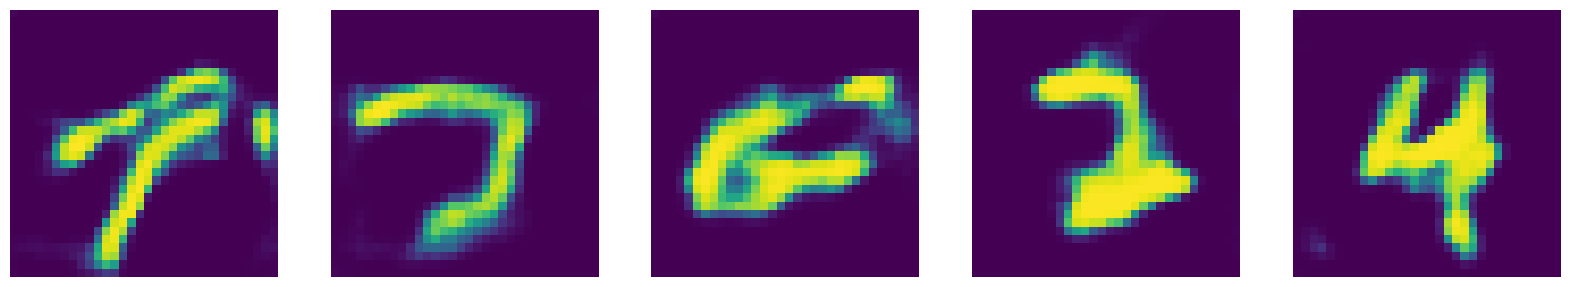

Epoch 4


469batch [01:12,  6.50batch/s, Remaining Time=00:01]                      


generated images


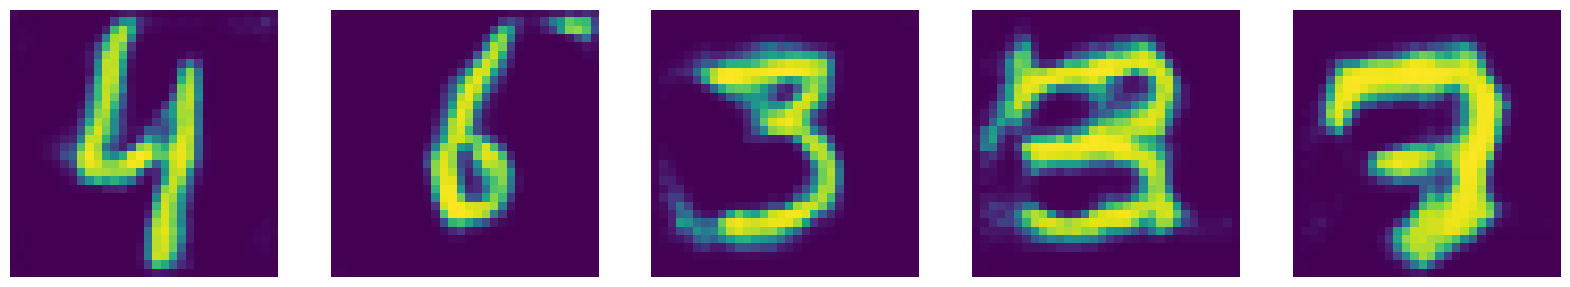

Epoch 5


469batch [01:12,  6.48batch/s, Remaining Time=00:01]                      


generated images


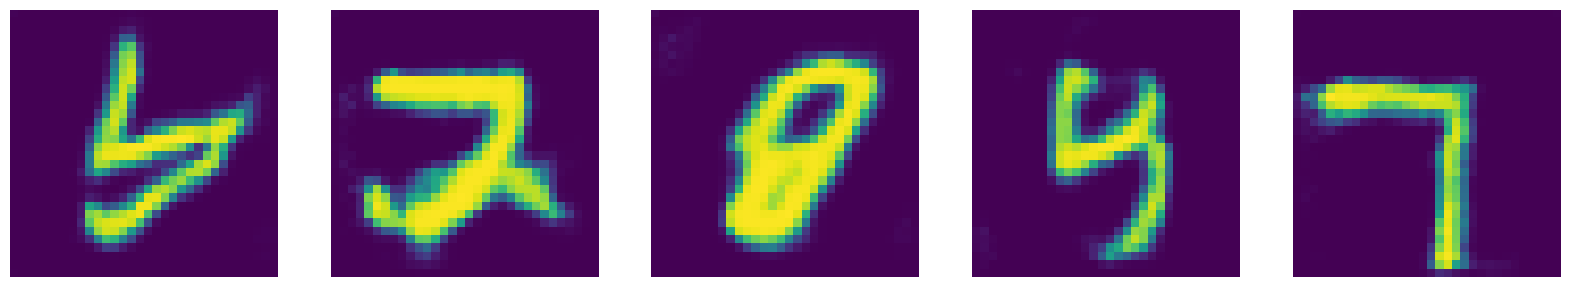

Epoch 6


469batch [01:12,  6.51batch/s, Remaining Time=00:01]                      


generated images


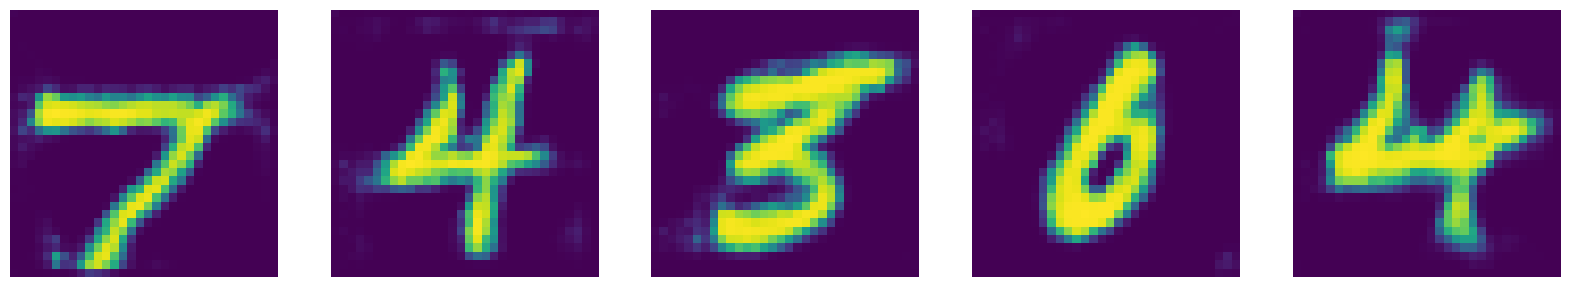

Epoch 7


469batch [01:12,  6.47batch/s, Remaining Time=00:00]                      


generated images


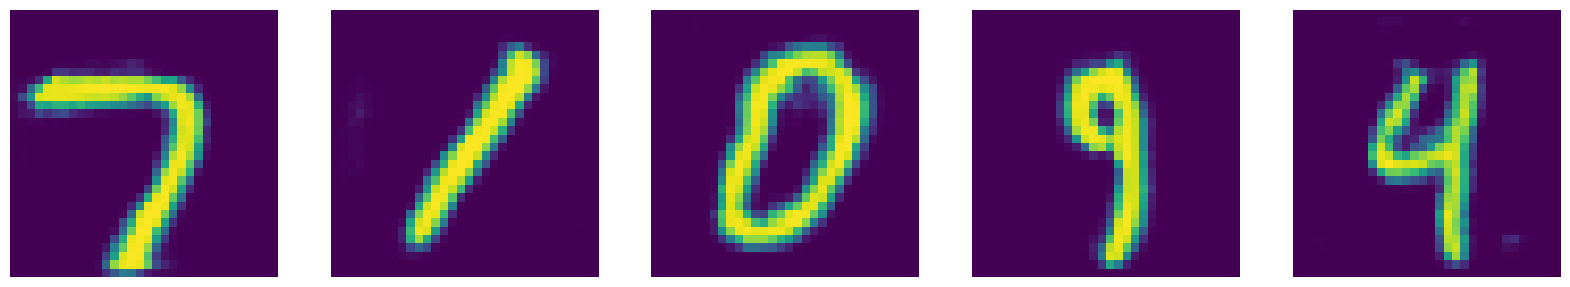

Epoch 8


469batch [01:12,  6.50batch/s, Remaining Time=00:00]                      


generated images


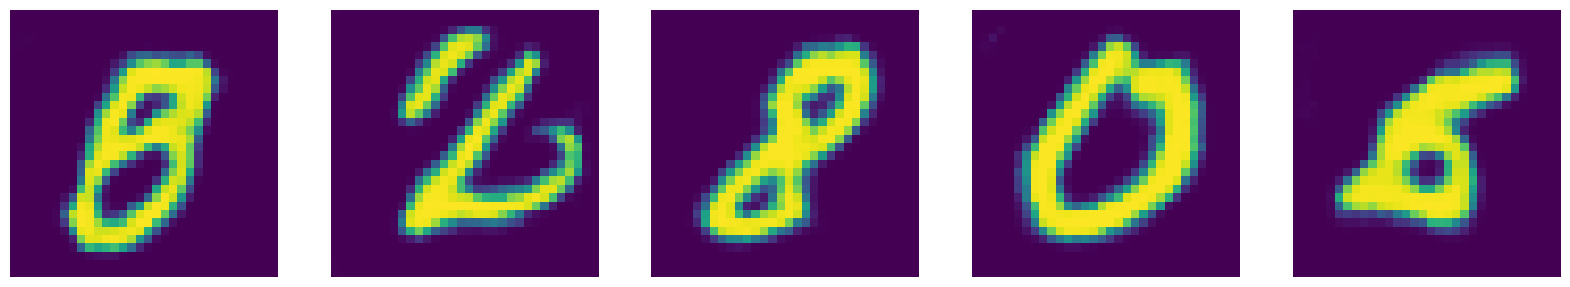

Epoch 9


469batch [01:12,  6.50batch/s, Remaining Time=00:00]                      


generated images


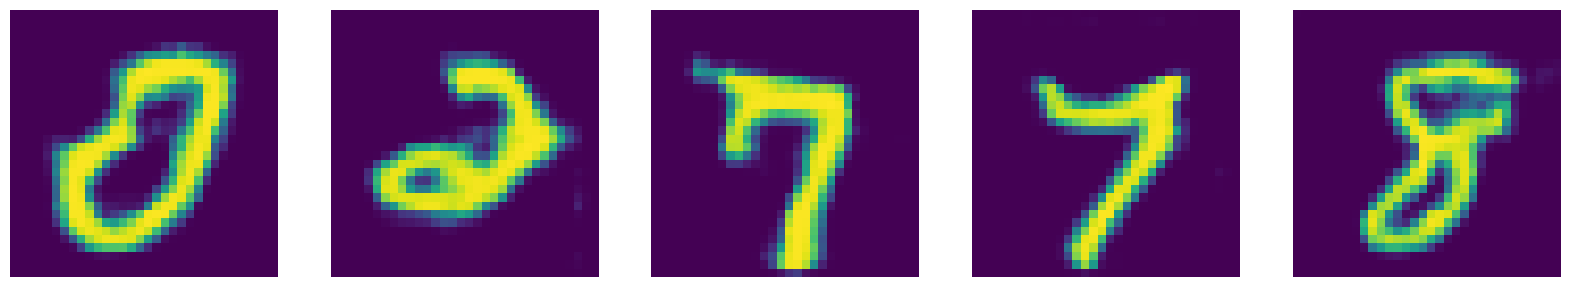

Epoch 10


469batch [01:12,  6.48batch/s, Remaining Time=00:00]                      


generated images


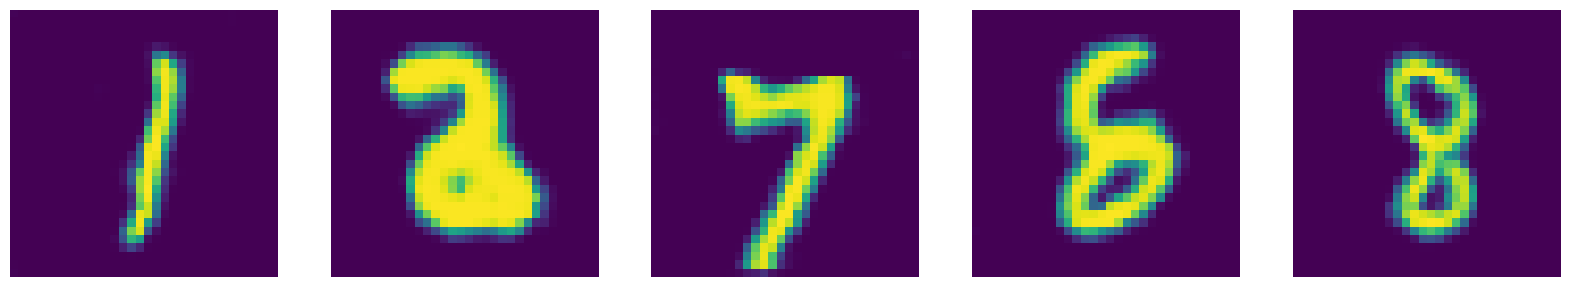

Epoch 11


469batch [01:12,  6.50batch/s, Remaining Time=00:00]                      


generated images


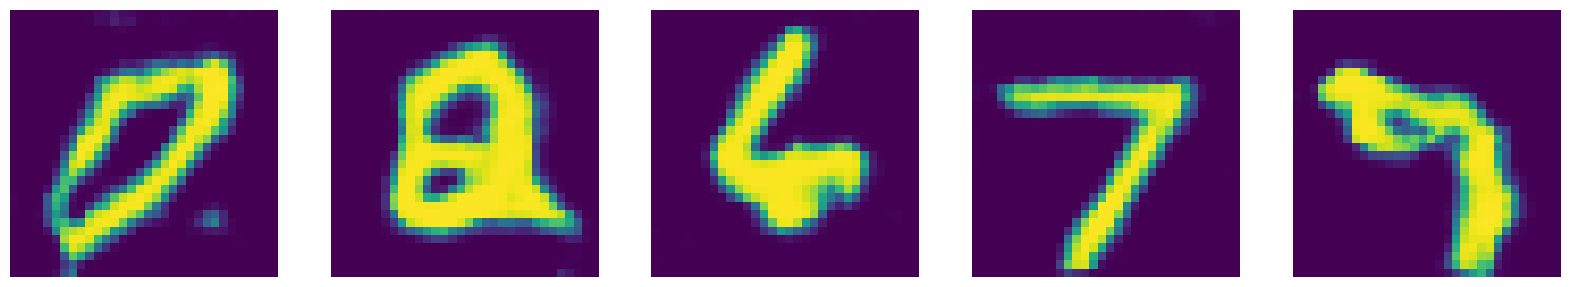

Epoch 12


469batch [01:12,  6.50batch/s, Remaining Time=00:00]                      


generated images


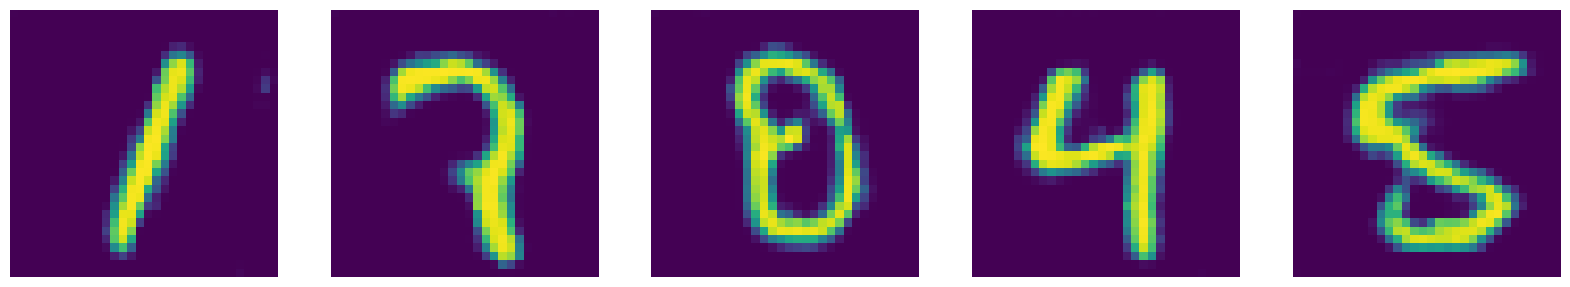

Epoch 13


469batch [01:12,  6.49batch/s, Remaining Time=00:00]                      


generated images


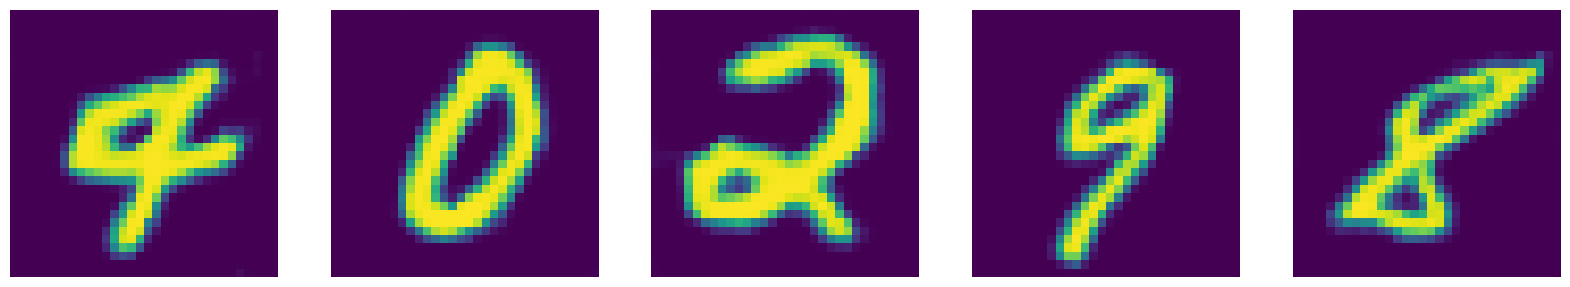

Epoch 14


469batch [01:12,  6.47batch/s, Remaining Time=00:00]                      


generated images


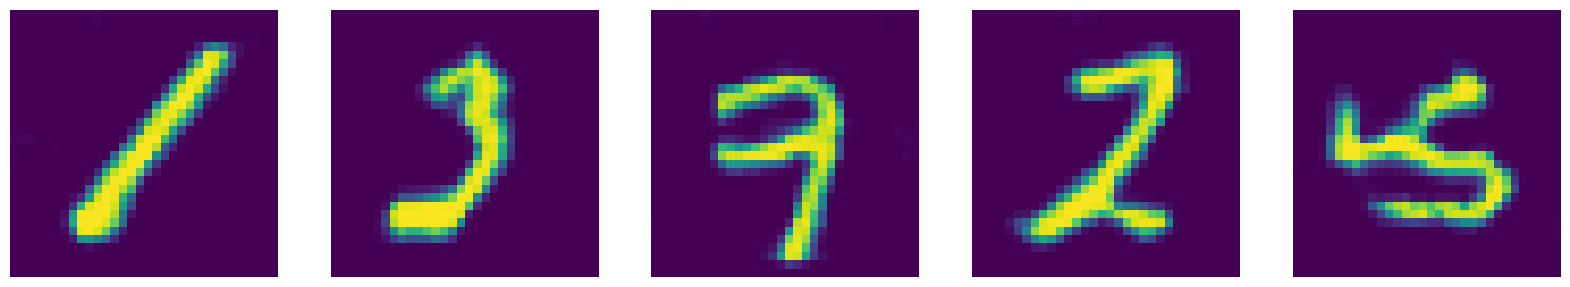

Epoch 15


469batch [01:12,  6.44batch/s, Remaining Time=00:00]                      


generated images


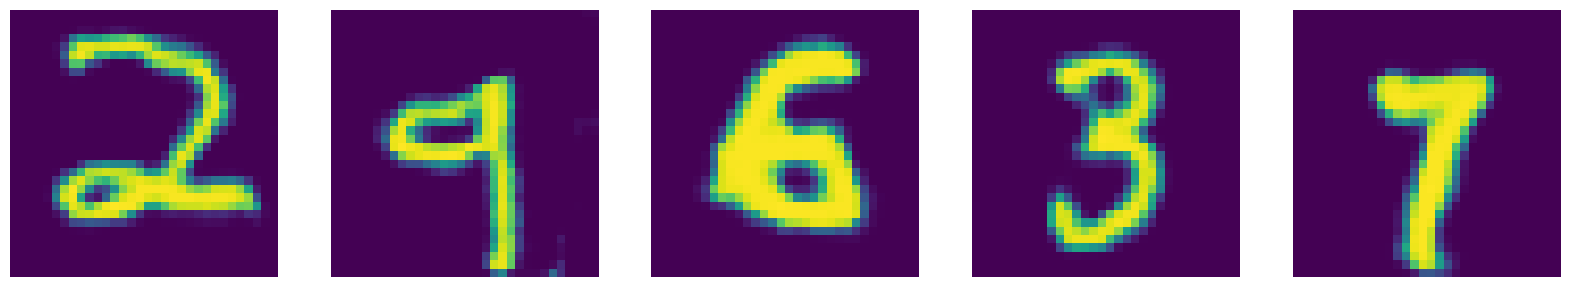

Epoch 16


469batch [01:12,  6.45batch/s, Remaining Time=00:00]                      


generated images


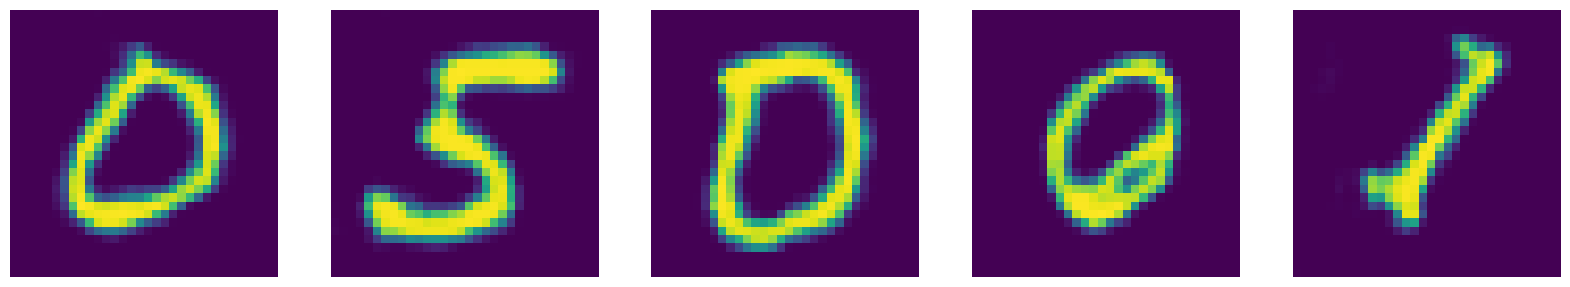

Epoch 17


469batch [01:12,  6.45batch/s, Remaining Time=00:00]                      


generated images


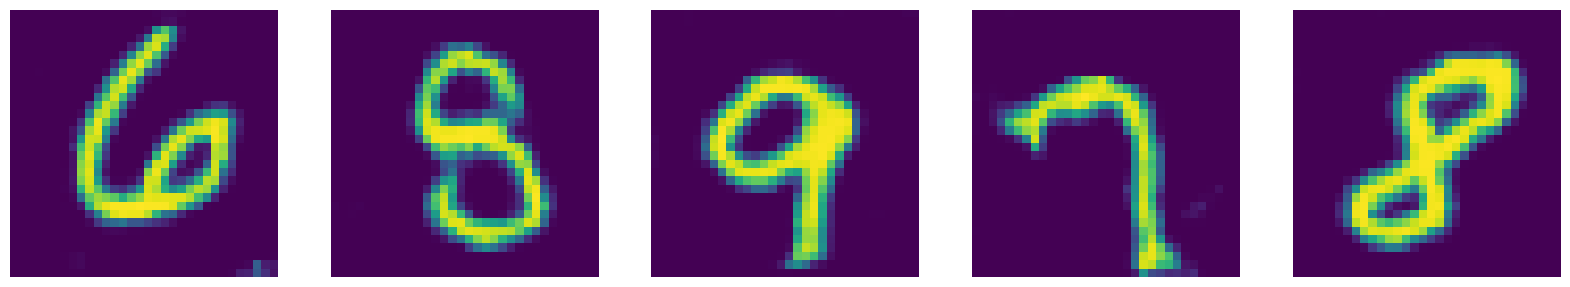

Epoch 18


469batch [01:12,  6.46batch/s, Remaining Time=00:00]                      


generated images


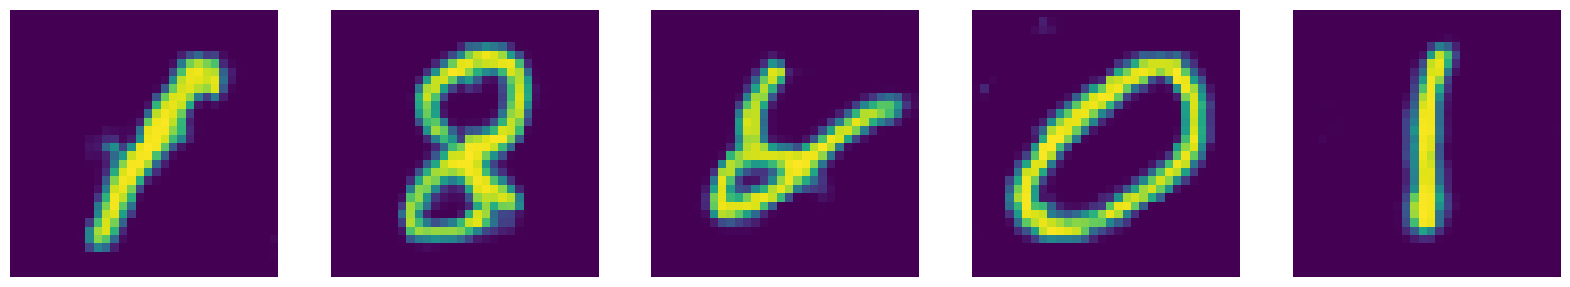

Epoch 19


469batch [01:12,  6.44batch/s, Remaining Time=00:00]                      


generated images


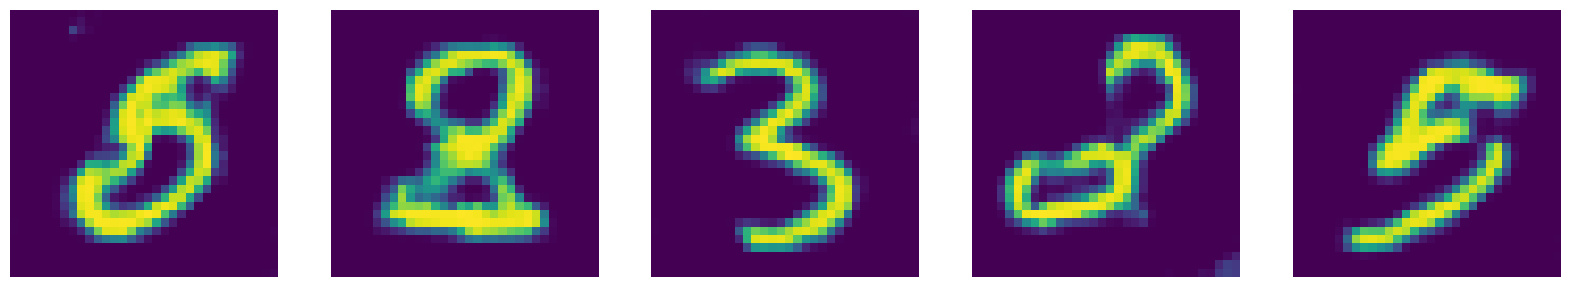

Epoch 20


469batch [01:12,  6.45batch/s, Remaining Time=00:00]                      


generated images


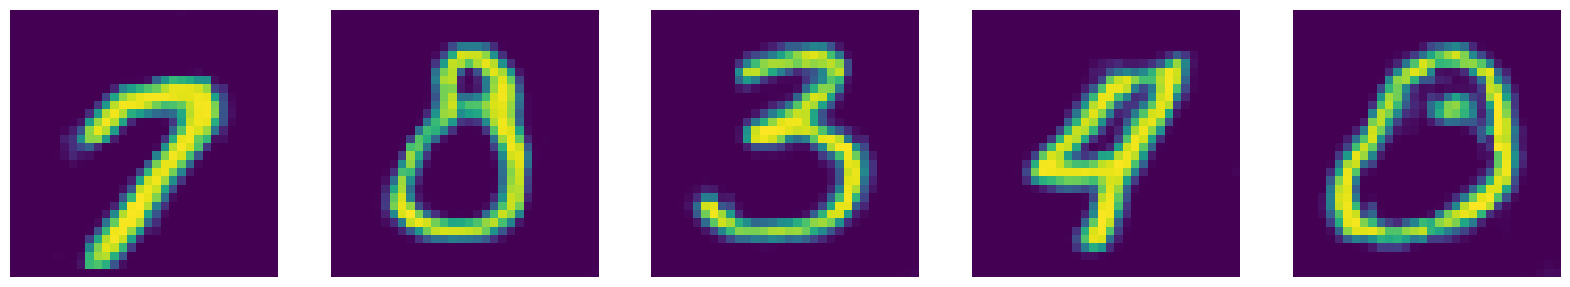

In [61]:
start_t = time.time()
for epoch in range(epochs):
    print("Epoch", epoch + 1)
    
    
    
    # Split the training data into batches
    num_batches = X_train.shape[0] // BATCH_SIZE
    
    with tqdm(total=num_batches, unit='batch') as pbar:
        for i in range(0, X_train.shape[0], BATCH_SIZE):
            images = X_train[i:i+BATCH_SIZE]
            train_step(images)
            pbar.update(1)
            pbar.set_postfix({'Remaining Time': pbar.format_interval(pbar.n / (time.time() - start_t))})

    
    # Generate all images after each epoch
    z = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    generated_images = generator(z, training=False)
    
    
        
    print("generated images")
    plot_array(generated_images)
    
    